<a href="https://colab.research.google.com/github/LidorErez98/Data-Projects/blob/main/S%26P_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [138]:
#!pip install pandas_ta

In [277]:
import calendar

# Finance Data
import yfinance as yf

# Data Manipulation
import pandas as pd
import polars as pl
import pandas_ta as ta
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

pio.renderers.default='svg'

# S&P Daily Data

In [208]:
df = yf.download('^GSPC', start = '2001-01-01', end='2023-05-25', interval='1d')
dates = list(df.index)
df = pl.DataFrame(df)

[*********************100%***********************]  1 of 1 completed


In [209]:
df.to_pandas().head()

,Open,High,Low,Close,Adj Close,Volume
0,1320.280029,1320.280029,1276.050049,1283.270020,1283.270020,1129400000
1,1283.270020,1347.760010,1274.619995,1347.560059,1347.560059,1880700000
2,1347.560059,1350.239990,1329.140015,1333.339966,1333.339966,2131000000
3,1333.339966,1334.770020,1294.949951,1298.349976,1298.349976,1430800000
4,1298.349976,1298.349976,1276.290039,1295.859985,1295.859985,1115500000


## Feature engineering

#### Date related columns

In [210]:
# Creating Date, Year, Month, Day columns
dates = pl.Series(pd.Series(dates).dt.date) # extracting date from datetime col


temp = df.with_columns(
    (dates).alias('Date')
)

months = pl.Series(temp.to_pandas()['Date'].dt.strftime('%b'))
days = pl.Series(temp.to_pandas()['Date'].dt.strftime('%a'))
year = pl.Series(temp.to_pandas()['Date'].dt.strftime('%Y'))
day_num = pl.Series(temp.to_pandas()['Date'].dt.strftime('%d'))
mon_num  = pl.Series(temp.to_pandas()['Date'].dt.strftime('%m'))

dates_df = pl.DataFrame(
    [(dates.cast(pl.Utf8)).alias('Date'),
    (year).alias('Year'),
    (months).alias('Month'),
    (days).alias('Day'),
    (day_num).alias('Day (num)'),
    (mon_num).alias('Month (num)')]
).to_pandas()

df = pd.concat([dates_df, df.to_pandas()],axis=1)

In [211]:
# Changing back to polars
df = pl.DataFrame(df)
df.to_pandas().head()

,Date,Year,Month,Day,Day (num),Month (num),Open,High,Low,Close,Adj Close,Volume
0,2001-01-02,2001,Jan,Tue,02,01,1320.280029,1320.280029,1276.050049,1283.270020,1283.270020,1129400000
1,2001-01-03,2001,Jan,Wed,03,01,1283.270020,1347.760010,1274.619995,1347.560059,1347.560059,1880700000
2,2001-01-04,2001,Jan,Thu,04,01,1347.560059,1350.239990,1329.140015,1333.339966,1333.339966,2131000000
3,2001-01-05,2001,Jan,Fri,05,01,1333.339966,1334.770020,1294.949951,1298.349976,1298.349976,1430800000
4,2001-01-08,2001,Jan,Mon,08,01,1298.349976,1298.349976,1276.290039,1295.859985,1295.859985,1115500000


#### % of Change (Daily)

In [212]:
# % Change Daily and Close Price Change
df = df.with_columns(
    ((pl.col('Close') - pl.col('Open'))/pl.col('Open') * 100).alias('Change (%)'),
    (pl.col('Close').pct_change()*100).alias('Close Price Change')
)

# Selecting the new columns
df.select([
    pl.col('Close Price Change'),
    pl.col('Change (%)')
]).head(5)

Close Price Change,Change (%)
f64,f64
null,-2.803194
5.009861,5.009861
-1.055247,-1.055247
-2.624236,-2.624236
-0.191781,-0.191781


#### Volatility

In [213]:
# Volatility
df=df.with_columns(((pl.col('High')/pl.col('Low') - 1)*100).alias('Volatility'))

df.select([pl.col('Volatility')]).head(5)

Volatility
f64
3.466163
5.738182
1.587491
3.075028
1.728442


#### Trend (Positive / Negative)

In [214]:
# Creating a trend column
df = df.with_columns(
    pl.col('Change (%)').apply(lambda x: 'Uptrend' if x > 0 else 'Downtrend').alias('Trend')
)

df.select([
    pl.col('Trend')
]).head(5)

Trend
str
"""Downtrend"""
"""Uptrend"""
"""Downtrend"""
"""Downtrend"""
"""Downtrend"""


#### Quarter

In [215]:
months = [month[:3] for month in calendar.month_name[1:]]

def quarter_handler(month):
  """
  Takes a month and returns it's quarter
  """
  if month in months[:3]:
    return 'Q1'
  elif month in months[3:6]:
    return 'Q2'
  elif month in months[6:9]:
    return 'Q3'
  return 'Q4'

# Create the quarter column (Q1, Q2, Q3, Q4)
df=df.with_columns(
    pl.col('Month').apply(lambda x: quarter_handler(x)).alias('Quarter')
)

df.select([
    pl.col('Quarter')
]).unique()

Quarter
str
"""Q1"""
"""Q3"""
"""Q2"""
"""Q4"""


#### Moving Averages

* Bollinger Bands: determine whether the prices are high or low
* SMA: Moving Average
* EMA: Exponential Moving Average

In [216]:
df = df.to_pandas() # converting to pandas to use pandas_ta library

df.ta.bbands(close = df['Close'],length = 20,num_std = 2,append=True) # Boillinger Bands

# Moving Averages
df['SMA_50'] = ta.sma(df['Close'],length=50) 
df['SMA_200'] = ta.sma(df['Close'], length=200)

# Exponential Moving Average
df.ta.ema(8, append=True)
df.ta.ema(12, append=True)
df.ta.ema(26, append=True)

# MACD (Difference between SMA_50 & SMA_200 and between ema12 & ema26)
df['MACD'] = df['SMA_50'] - df['SMA_200']
df['MACD_e'] = df['EMA_12'] - df['EMA_26']

# MACD Signal Line
df['MACD_line'] = ta.ema(df['MACD'], length=9)
df['MACD_e_line'] = ta.ema(df['MACD_e'], length=9)

#### Oscillators

* RSI Indicator: Indicates overbought or oversold.
* RSI divergence: measures the difference between the current RSI value and its previous value.
* ADX Indicator: Indicates the strength of a trend.
* CCI Indicator: Indicates the difference between historical price mean and today's price
* Stoch Indicator: Indicates overbought or oversold (using high & low)


In [217]:
df.ta.rsi(14,append=True) # RSI indicator
df['RSI_diff'] = df['RSI_14'].diff() # RSI divergence
df.ta.adx(append=True) # ADX Indicator
df.ta.stoch(append=True) # Stoch Indicator
df.ta.cci(20, append=True) # CCI Indicator
df.ta.willr(append=True)
df = pl.DataFrame(df) # back to polars

#### Lagged Values

* Roc indicator: indicates the rate of change of the close prices

In [218]:
# Adding Lagged Price values

df = df.with_columns(
    pl.col('Close').shift(252).alias('LaggedClose(Year)'),
    pl.col('Close').shift(30).alias('LaggedClose(Month)'),
    pl.col('Close').shift(7).alias('LaggedClose(Week)'),
    pl.col('Close').shift(3).alias('LaggedClose(3Days)')
)


# Calculating period ROC 

lagged_cols = list(df.columns[::-1][0:4])
lagged_timestamps = [col.split('(')[-1].replace(')','') for col in lagged_cols]

df = df.with_columns(
    ((pl.col('Close') - pl.col(f'LaggedClose({val})'))/pl.col(f'LaggedClose({val})')).alias(f'Lagged_{val}_Change') for val in lagged_timestamps
)

## Exploratory Data Analysis

In [219]:
df.shape

(5634, 48)

In [220]:
df.to_pandas().isna().sum()

Date                     0
Year                     0
Month                    0
Day                      0
Day (num)                0
Month (num)              0
Open                     0
High                     0
Low                      0
Close                    0
Adj Close                0
Volume                   0
Change (%)               0
Close Price Change       1
Volatility               0
Trend                    0
Quarter                  0
BBL_20_2.0              19
BBM_20_2.0              19
BBU_20_2.0              19
BBB_20_2.0              19
BBP_20_2.0              19
SMA_50                  49
SMA_200                199
EMA_8                    7
EMA_12                  11
EMA_26                  25
MACD                   199
MACD_e                  25
MACD_line              199
MACD_e_line             25
RSI_14                  14
RSI_diff                15
ADX_14                  27
DMP_14                  14
DMN_14                  14
STOCHk_14_3_3           15
S

After adding some features to the data frame, missing values have been added as well. Therefore, operation for handling those values will be used in later on.

In [221]:
df.to_pandas().dtypes

Date                    object
Year                    object
Month                   object
Day                     object
Day (num)               object
Month (num)             object
Open                   float64
High                   float64
Low                    float64
Close                  float64
Adj Close              float64
Volume                   int64
Change (%)             float64
Close Price Change     float64
Volatility             float64
Trend                   object
Quarter                 object
BBL_20_2.0             float64
BBM_20_2.0             float64
BBU_20_2.0             float64
BBB_20_2.0             float64
BBP_20_2.0             float64
SMA_50                 float64
SMA_200                float64
EMA_8                  float64
EMA_12                 float64
EMA_26                 float64
MACD                   float64
MACD_e                 float64
MACD_line              float64
MACD_e_line            float64
RSI_14                 float64
RSI_diff

In [222]:
df.describe()

describe,Date,Year,Month,Day,Day (num),Month (num),Open,High,Low,Close,Adj Close,Volume,Change (%),Close Price Change,Volatility,Trend,Quarter,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,SMA_50,SMA_200,EMA_8,EMA_12,EMA_26,MACD,MACD_e,MACD_line,MACD_e_line,RSI_14,RSI_diff,ADX_14,DMP_14,DMN_14,STOCHk_14_3_3,STOCHd_14_3_3,CCI_20_0.015,WILLR_14,LaggedClose(Year),LaggedClose(Month),LaggedClose(Week),LaggedClose(3Days),Lagged_3Days_Change,Lagged_Week_Change,Lagged_Month_Change,Lagged_Year_Change
str,str,str,str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""5634""","""5634""","""5634""","""5634""","""5634""","""5634""",5634.0,5634.0,5634.0,5634.0,5634.0,5634.0,5634.0,5634.0,5634.0,"""5634""","""5634""",5634.0,5634.0,5634.0,5634.0,5634.0,5634.0,5634.0,5634.0,5634.0,5634.0,5634.0,5634.0,5634.0,5634.0,5634.0,5634.0,5634.0,5634.0,5634.0,5634.0,5634.0,5634.0,5634.0,5634.0,5634.0,5634.0,5634.0,5634.0,5634.0,5634.0,5634.0
"""null_count""","""0""","""0""","""0""","""0""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"""0""","""0""",19.0,19.0,19.0,19.0,19.0,49.0,199.0,7.0,11.0,25.0,199.0,25.0,199.0,25.0,14.0,15.0,27.0,14.0,14.0,15.0,17.0,19.0,13.0,252.0,30.0,7.0,3.0,3.0,7.0,30.0,252.0
"""mean""",null,null,null,null,null,null,1931.708091,1943.07366,1919.410063,1931.972941,1931.972941,3.4141e9,0.019488,0.028373,1.31673,null,null,1867.478067,1929.261032,1991.043996,6.553609,0.571907,1925.015795,1906.406965,1930.97854,1930.406327,1928.393974,38.239964,3.482666,38.088605,3.478683,53.859187,-0.004245,22.738614,24.211775,23.83349,61.205682,61.199643,23.28219,-38.793874,1836.563883,1920.179238,1929.202666,1930.790641,0.000806,0.001857,0.007731,0.072362
"""std""",null,null,null,null,null,null,1013.970522,1019.366738,1008.115925,1014.106512,1014.106512,1.4748e9,1.123384,1.238553,1.028622,null,null,977.579316,1010.537553,1045.603784,4.600214,0.327492,1005.196179,981.13223,1012.579594,1011.761749,1009.034542,121.563899,24.615026,121.192147,22.955882,11.249629,4.655652,7.837979,7.080178,7.390035,29.207337,28.280433,108.85757,31.597875,933.738341,1003.885607,1011.687804,1013.081379,0.01976,0.028707,0.056611,0.166721
"""min""","""2001-01-02""","""2001""","""Apr""","""Fri""","""01""","""01""",679.280029,695.27002,666.789978,676.530029,676.530029,0.0,-8.7231,-11.984055,0.145747,"""Downtrend""","""Q1""",648.975559,736.972003,806.269033,1.049483,-0.466826,788.956798,870.5725,705.180472,721.480822,756.723226,-438.560785,-237.020227,-428.996415,-198.640715,13.639288,-25.69281,8.137028,5.336316,5.280384,0.866648,1.116495,-401.396755,-100.0,676.530029,676.530029,676.530029,676.530029,-0.139059,-0.225518,-0.327646,-0.488228
"""max""","""2023-05-24""","""2023""","""Sep""","""Wed""","""31""","""12""",4804.509766,4818.620117,4780.040039,4796.560059,4796.560059,1.1456e10,10.789006,11.580037,11.520845,"""Uptrend""","""Q4""",4610.997106,4716.387012,4925.005874,43.353076,1.290744,4681.011611,4496.905588,4766.703368,4748.018945,4705.028736,385.823407,92.583711,382.630963,81.88411,86.68665,21.757369,55.046211,51.345736,62.279876,99.928362,99.057406,286.419348,0.0,4796.560059,4796.560059,4796.560059,4796.560059,0.175503,0.174153,0.282042,0.747797
"""median""",null,null,null,null,null,null,1445.994995,1454.809998,1436.410034,1446.890015,1446.890015,3.4849e9,0.052792,0.06127,1.043695,null,null,1407.406957,1445.56701,1483.409519,5.354452,0.652997,1434.477993,1448.193,1446.009556,1446.457135,1441.358163,53.0527,6.145363,52.968705,5.73808,54.98002,0.313936,21.378304,24.407701,22.94282,68.268144,68.152248,51.10135,-31.510879,1411.415039,1440.400024,1445.900024,1445.939941,0.002122,0.004312,0.015005,0.099529
"""25%""",null,null,null,null,null,null,1178.140015,1185.150024,1169.910034,1178.099976,1178.099976,2.3572e9,-0.437885,-0.471244,0.677265,null,null,1136.272442,1179.543994,1217.402847,3.753991,0.309545,1177.868203,1

## Deep dive into data

#### What is the overall daily trend of S&P ?

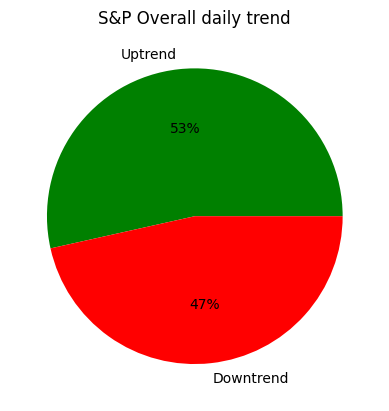

In [278]:
plt.pie(df['Trend'].value_counts(sort=True)['counts'],
        labels=['Uptrend','Downtrend'],
        colors=['green','red'],
        autopct='%.0f%%')
plt.title('S&P Overall daily trend')
plt.show()

#### Is there a significant difference in volatility between the different days of the week?

In [224]:
ticks = ['Monday','Tuesday','Wednesday','Thursday','Friday']

fig = px.box(
    x=df['Day'],
    y=df['Volatility'],
    labels = dict(
        x="Day",
        y='Volatility'
    ),
    title = 'Variation in Volatility of S&P Index by Day of Week'
)

fig.update_layout(
    xaxis = dict(
        categoryorder = 'array',
        categoryarray = ticks,
        tickfont = dict(size=12),
        position = 0
    ),
    boxgap = 0.5,
    width = 800,
    height= 500,
    title_x = 0.5
)

fig.show()

Though there are some outliers in data that are pointing on extreme volatility at a certain day, there is a small difference between each day.

#### Which Day(s) typically show a positive change 

In [225]:
# Creating days list
days = [day[:3] for day in calendar.day_name if day[:3] in df['Day'].unique()]
years = df['Year'].unique().to_list()
# Calculating the amount of uptrends&downtrends for each day
trend_df = df.to_pandas().groupby('Day')['Trend'].value_counts()
down_trend = trend_df.tolist()[1::2]
up_trend = trend_df.tolist()[::2]



In [226]:
# Calculating the % of total trends for each type of trend
for i in range(len(up_trend)):
    sum_of_trends = down_trend[i] + up_trend[i]
    up_trend[i] =  up_trend[i]/sum_of_trends * 100
    down_trend[i] = down_trend[i]/sum_of_trends * 100



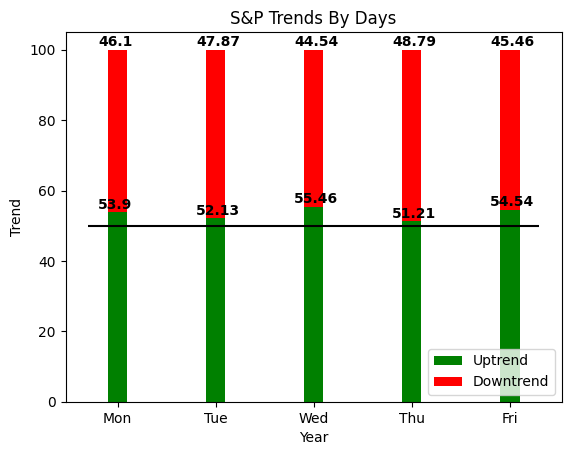

In [227]:
# Creating the stacked bar plot
width = 0.2
up_trend_bar = plt.bar(
    days,
    up_trend,
    width,
    color='Green'
)

down_trend_bar = plt.bar(
    days,
    down_trend,
    width,
    bottom = up_trend,
    color='Red'
)

for i , (up_val, down_val) in enumerate(zip(up_trend, down_trend)):

  plt.text(
      i - 0.2,
      up_val + 1,
      str(np.round(up_val,2)),
      color='black',
      fontweight='bold'
  )

  plt.text(
      i - 0.2,
      down_val + up_val + 1,
      str(np.round(down_val,2)),
      color='black',
      fontweight='bold'
  )

plt.ylabel('Trend')
plt.xlabel('Year')
plt.title('S&P Trends By Days')
plt.legend((up_trend_bar[0],down_trend_bar[0]),
           ('Uptrend','Downtrend'),
           loc='lower right')
plt.hlines(50,xmin=-0.3,xmax =4.3,color='black')
plt.show()

With the black line at 50%, I can clearly determine which days have mostly positive changes in the S&P. Based on this, my conclusions are:

- Wednesday is likely to have a more positive change in the S&P % compared to other trading days.

- Although Wednesday has the most positive changes, the S&P % change is still positive more than 50% of the time on other days.

There's no significance difference between the days.

#### What is the average S&P % of change over the months? 

In [228]:
df_pd = df.to_pandas()
fig = px.line(
x=df_pd['Month'].unique().tolist(),
y=df_pd.groupby('Month')['Change (%)'].mean(),
markers=True,
    labels=dict(
x="Month",
y='S&P % of change'),
title = 'S&P Daily Average % of change over the months')

fig.update_layout(
        title_x = 0.5
    )
fig.show()

Within Quarters:

* First Quarter: there's a decrease from Jan to Mar.
* Second Quarter: there's a decrease from Apr to May and an increase from May to Jun.
* Third Quarter: there's an increase from Jul to Aug and a decrease from Aug to Sep. 
* Forth Quarter: there's a decrease from Oct to Dec.

Between Quarters:

* First Quarter to Second Quarter: an increase introduced.
* Second Quarter to Third Quarter: a decrease introduced.
* Third Quarter to Forth Quarter: an increase introduced.

#### What is the average S&P % of change over the quarters? 

In [229]:
px.line(
x=df_pd['Quarter'].unique().tolist(),
y=df_pd.groupby('Quarter')['Change (%)'].mean(),
markers=True,
    labels=dict(
x="Quarter",
y='S&P % of change'),
title = 'S&P Daily Average % of change over the quarters')

Though there's a decrease from Mar to Apr the average change of the first quarter is bigger than the average change of the second quarter.

#### How do the SMA50 and SMA200 indicators behave over different timeframes?

In [230]:
def sma_plot(timeframe, data, title):
    fig = px.line(
    x= data[timeframe].unique(),
    y= data.groupby(timeframe)['SMA_50'].mean(numeric_only=True),
    color_discrete_sequence = ['red'],
    labels = dict(
    x='Month',
    y= 'SMA'
    ),
    markers=True,
    title = title
)

    fig2 =  px.line(
        x= data[timeframe].unique(),
        y= data.groupby(timeframe)['SMA_200'].mean(numeric_only=True),
        color_discrete_sequence = ['orange'],
        labels = dict(
        x='Month',
        y= 'SMA'
        ),
        markers=True
    )

    fig.update_traces(name='SMA 50',showlegend=True)
    fig2.update_traces(name='SMA 200',showlegend=True)

    for data_ in fig2.data:
        fig.add_trace(data_)
        
    fig.update_layout(
        title_x = 0.5
    )
    fig.show()

In [231]:
sma_plot('Month',df_pd, 'SMA50 VS SMA200 over the months')

In [232]:
sma_plot('Quarter',df_pd, 'SMA50 VS SMA200 over the quarters')

In [233]:
sma_plot('Year',df_pd, 'SMA50 VS SMA200 over the Years')

When sma50 line is above the sma200 line it's probably a good time to invest. However, there's no 100% gurantee that these lines indicate the right time to buy / not to buy.

According to the indicator mentioned above, S&P index is a safe stock to trade in the stock market.

#### Does MACD calculated from sma is better at predicting close prices trends than MACD calculated from ema?

In [234]:
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.1)

fig.add_trace(go.Scatter(x=df_pd['Month'].unique(),
                         y=df_pd.groupby('Month')['Close'].mean(), 
                         mode='lines', 
                         name='Close Prices'), row=1, col=1)

fig.add_trace(go.Scatter(x=df_pd['Month'].unique(),
                         y=df_pd.groupby('Month')['MACD'].mean(),
                         mode='lines', 
                         name='MACD Line'), row=2, col=1)

fig.add_trace(go.Scatter(x=df_pd['Month'].unique(),
                         y=df_pd.groupby('Month')['MACD_line'].mean(),
                         mode='lines', 
                         name='MACD Signal Line'), row=2, col=1)

fig.update_layout(
    title='Close prices & MACD Line & Signal Line over the months',
    title_x = 0.5
)
fig.show()


In [235]:
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.1)

fig.add_trace(go.Scatter(x=df_pd['Month'].unique(),
                         y=df_pd.groupby('Month')['Close'].mean(), 
                         mode='lines', 
                         name='Close Prices'), row=1, col=1)

fig.add_trace(go.Scatter(x=df_pd['Month'].unique(),
                         y=df_pd.groupby('Month')['MACD_e'].mean(),
                         mode='lines', 
                         name='MACD EWM Line'), row=2, col=1)

fig.add_trace(go.Scatter(x=df_pd['Month'].unique(),
                         y=df_pd.groupby('Month')['MACD_e_line'].mean(),
                         mode='lines', 
                         name='MACD EWM Signal Line'), row=2, col=1)

fig.update_layout(
    title='Close prices & MACD EWM Line & Signal Line over the months',
    title_x = 0.5
)
fig.show()


It seems that the EMA MACD line is better at predicting the closing price trend compared to the nomral MACD which is calculated using sma50 and sma200. Thus, EMA MACD might be more appropriate indicator for the S&P index when trading daily.

## Models

### Predict the S&P Daily % of Change

In [236]:
# Importing metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Importing model
from sklearn.ensemble import RandomForestRegressor

# Train - Test split ,  Time series cross validation,  Hyperparameters tuning

from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV

#### Data Preparation

In [237]:
df_2023 = df.lazy().filter(pl.col("Year") == "2023" ).collect()

df = df.lazy().filter(pl.col("Year") != "2023").collect()

# One hot encoding quarter & trend
df_models = pl.concat([df,df['Quarter'].to_dummies(),
                       df['Trend'].to_dummies(),
                       df['Year'].to_dummies(),
                       df['Day'].to_dummies(),
                       df['Month'].to_dummies()]
                      ,how='horizontal')

df_models2023 = pl.concat([df_2023,df_2023['Quarter'].to_dummies(),
                       df_2023['Trend'].to_dummies(),
                       df_2023['Year'].to_dummies(),
                       df_2023['Day'].to_dummies(),
                       df_2023['Month'].to_dummies()]
                      ,how='horizontal')

df_models = df_models.to_pandas() # to pandas transformation for interpolation

Spline interpolation uses a low-degree polynomials to small subsets of the values instead of fitting a single, high-degree polynomial to all of the values at once. for further reading: [Spline Interpolation](https://en.wikipedia.org/wiki/Spline_interpolation)

In [238]:
# Find columns with missing values
missing_values_cols = list(df_models.columns[df_models.isnull().any()])

# Fill missing values using interpolation (spline method)
for col in missing_values_cols:
  df_models[col].interpolate(
      method='spline',
      order=3,
      inplace=True,
      limit_direction = 'backward'
  )

In [239]:
# Dropping unnecessary columns (including target variable)
x = df_models.drop(columns=['Change (%)', 
                            'Month (num)',
                            'Day (num)', 
                            'Date',
                            'Month',
                            'Day',
                            'Year',
                            'Trend',
                            'Quarter',
                            'Adj Close']) 

y = df_models['Change (%)'] # target column

My goal is to predict the daily close price of the S&P using the features I've created and the features that came with the data. However, It's hard to determine the top features that predicts best the daily close price, therefore I'll be using Random Forest Regressor for feature selection.

#### RandomForestRegressor

In [240]:
# Create random forest regressor (default params)
rf_reg = RandomForestRegressor(random_state=1)

In [241]:
def model_fitting(x,y ,splits,model):
  """
  This function uses random forest regressor and time series cross validation to predict
  the s&p daily % of change.

  X = independent variables
  y = depdendent variable
  rf_reg = random forest regressor model

  After fitting the model and predicting response variable values the function returns the following:

  1. evaluation metrics (mse, mae, rmse, r2), 
  2. avg_scores,
  3. feature_names,
  4. importance (random forest feature importance)
  """

  evaluation_metrics = {'mse':[],
                        'mae':[],
                        'rmse':[],
                        'r2':[],
                        'oob':[],
                        'pred':[],
                        'real':[]}

  # Time series CrossValidation
  tscv = TimeSeriesSplit(n_splits=splits)

  for train_idx, val_idx in tscv.split(x):

    # Train - Test Split
    x_train, x_validate = x.iloc[train_idx], x.iloc[val_idx]
    y_train, y_validate = y.iloc[train_idx], y.iloc[val_idx]

    # Fit the model

    model.fit(x_train, y_train)

    # Predict change (%)

    y_pred = model.predict(x_validate)

    # Model Evaluation

    mse = mean_squared_error(y_validate, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_validate, y_pred)
    r2 = r2_score(y_validate, y_pred)

    evaluation_metrics['mse'].append(mse)
    evaluation_metrics['mae'].append(mae)
    evaluation_metrics['rmse'].append(rmse)
    evaluation_metrics['r2'].append(r2)
    evaluation_metrics['pred'].append(y_pred)
    evaluation_metrics['real'].append(y_validate)

  avg_scores = {
      key : np.mean(evaluation_metrics[key])
      for key in list(evaluation_metrics.keys())[:4]
  }

  importance = np.exp(model.feature_importances_) # Feature importance
  feature_names = list(x.columns) # feature names

  # Sorting features by their importance
  feature_importance = dict(sorted(dict(zip(feature_names,importance)).items(), 
                                     key=lambda item: item[1], reverse=True)) 

  feature_names = list(feature_importance.keys())
  importance = list(feature_importance.values())

  return evaluation_metrics, avg_scores, feature_names, importance

In [242]:
evaluation_metrics, avg_scores, feature_names, importance = model_fitting(x,y,5,rf_reg)

In [243]:
def feature_importance_bar(feature_names, importance):

  fig = px.bar(
      x = importance[:20],
      y = feature_names[:20],
      orientation = 'h',
      color = feature_names[:20],
      title = 'Top 20 features',
      labels = dict(
          x = 'Importance',
          y = 'Feature'
      )
  )

  fig.update_layout(
      legend = dict(
          title = 'Features'
      ),
      title_x = 0.5
  )

  fig.show()

In [244]:
feature_importance_bar(feature_names, importance)

##### Model Evaluation 

In [245]:
for k,v in avg_scores.items():
  print(f'{k} avg metric score : {v}')

mse avg metric score : 0.10378555115988904
mae avg metric score : 0.1518364666278781
rmse avg metric score : 0.2786001330955695
r2 avg metric score : 0.9185435150491154


##### Directional Accuracy 

In [246]:
def model_accuracy(y_validation, y_pred, title):

    # turning prediction data and actual data to 1 dim numpy array
    y_pred = np.vstack(y_pred).flatten()
    y_validation = np.vstack(y_validation).flatten()

    dct={
      'Pred':y_pred,
      'Real':y_validation
    }

    # Create pandas data frame
    pred_vs_real = pl.DataFrame(dct).to_pandas()

    # Calculate a moving average with a window of 100
    pred_mean = pred_vs_real['Pred'].rolling(window=100).mean()
    real_mean = pred_vs_real['Real'].rolling(window=100).mean()


    # Create line plots of prediction values and real values
    fig = px.line(
        real_mean,
        color_discrete_sequence=['black']
    )
   
    fig2 = px.line(
        pred_mean,
        color_discrete_sequence=['red'],
    )

    for data in fig2.data:
      fig.add_trace(data)

    fig.update_layout(
        legend=dict(
            title='Change (%)'
        ),
        title= f'Prediction Vs Real Value ({title})',
        title_x = 0.5
        
    )
    fig.show()

In [247]:
def trends_prediction(pred,real):
  trends = {
      'pred_positive':[],
      'real_positive':[],
      'pred_negative':[],
      'real_negative':[]
  }

  for i in range(len(pred)):

    pred_positive = sum(pred[i] > 0)
    pred_negative = sum(pred[i] < 0)

    real_positive = sum(real[i] > 0)
    real_negative = sum(real[i] < 0)

    trends['pred_positive'].append(pred_positive)
    trends['pred_negative'].append(pred_negative)
    
    trends['real_positive'].append(real_positive)
    trends['real_negative'].append(real_negative)

  return trends

In [248]:
def trend_bar(data):
  trends_df = pd.DataFrame(trends)
  
  fig = go.Figure()


  for column in trends_df.columns:
      fig.add_trace(
        go.Bar(
        x=[1,2,3,4,5],
        y=trends_df[column],
        name=column,
        text=trends_df[column],
        textposition='auto'
        )
      )

      fig.update_layout(barmode='group', 
      xaxis={'title': 'Folds'},
      yaxis={'title': 'Counts'},
      title='Trends Prediction',
      legend= dict(
          title = 'Trends'
      ))

  fig.show()

In [249]:
model_accuracy(
    evaluation_metrics['pred'],
    evaluation_metrics['real'],
    'Before hyperparameter tuning'
)

In [250]:
trends = trends_prediction(evaluation_metrics['pred'],evaluation_metrics['real'])
trend_bar(trends)

#### RandomForestRegressor - Hyper Parameter Tuning





In [251]:
temp = """
Finding the best params for the task


# Creating model:

rf_reg = RandomForestRegressor()

# settings params:

params = dict(
    n_estimators = [20,50,100,200,500],
    max_depth = np.arange(1,16,2),
    min_samples_split = [2,4,8,16],
    min_samples_leaf = np.arange(1,16,2,dtype=int), # gets integers only.
    bootstrap = [True, False],
    random_state = [42,1],
    max_features = ['sqrt','log2',None]
)

# Train - Test Split (for finding the right params)
x_train, x_test, y_train, y_test = train_test_split(x,y)


# Choose the right parameters using random search.
random_search_cv = RandomizedSearchCV(estimator=rf_reg,
                                      param_distributions=params,
                                      n_jobs = 1,
                                      verbose = 3,
                                      n_iter = 100,
                                      cv = 5,
                                      scoring = 'neg_mean_squared_error')

# fitting the model
random_search_cv.fit(x_train,
                     y_train)

# Getting the best params
best_params = random_search_cv.best_params_

print(best_params)
"""

Since random search cv is computationally expensive, I ran it once and got the following parameters:

1.   random_state: 42
2.   n_estimators: 500
3.   min_samples_split: 2
4.   min_samples_leaf: 1
5.   max_features: None
6.   max_depth: 13
7.   bootstrap: True

The next stage is to try to predict the target variable using these params.

In [252]:
rf_reg = RandomForestRegressor(
    n_estimators = 500,
    random_state = 42,
    min_samples_split = 2,
    min_samples_leaf = 1,
    max_features = None,
    max_depth = 13,
    bootstrap = True
)

fitting_data = model_fitting(x[feature_names[:20]],y,5,rf_reg)

##### Model Evaluation

In [253]:
for k,v in fitting_data[1].items():
  print(f'{k} avg metric score: {v}')

mse avg metric score: 0.10237472726766164
mae avg metric score: 0.14579280876936837
rmse avg metric score: 0.2681268247843357
r2 avg metric score: 0.9201453789562389


##### Directional Accuracy 

In [254]:
model_accuracy(fitting_data[0]['pred'],
               fitting_data[0]['real'],
               'After Hyperparameter Tuning')

In [255]:
trends = trends_prediction(fitting_data[0]['pred'],fitting_data[0]['real'])
trend_bar(trends)

#### With Hyperparameter tuning Vs Without Hyperparameter tuning

In [256]:
with_hpt = pd.DataFrame(fitting_data[1],index=['With']).T
without_hpt = pd.DataFrame(avg_scores,index=['Without']).T

tbl = pd.concat([with_hpt, without_hpt],axis=1)
tbl['Diff'] = (tbl['Without'] - tbl['With'])
tbl

,With,Without,Diff
mse,0.102375,0.103786,0.001411
mae,0.145793,0.151836,0.006044
rmse,0.268127,0.278600,0.010473
r2,0.920145,0.918544,-0.001602


By observing the Diff column which is the difference between without & with, I can clearly tell that the model's performance has improved.

#### Predict the S&P Daily % of Change 2023 data


In [ ]:
target = df_models2023['Change (%)']

features = df_models2023.drop(columns=['Change (%)', 
                            'Month (num)',
                            'Day (num)', 
                            'Date',
                            'Month',
                            'Day',
                            'Year',
                            'Trend',
                            'Quarter',
                            'Adj Close'])
df_2023

In [274]:
target_pred = rf_reg.predict(features[feature_names[:20]])

tbl2023 = pl.DataFrame(
    dict(
    target = target,
    target_pred = target_pred,
    diff = target - target_pred)
)

fig = px.line(
    target,
    color_discrete_sequence=['black']
)

fig.update_traces(name='Real value')



fig2 = px.line(
    target_pred,
    color_discrete_sequence=['red']
)

fig2.update_traces(name='Predicted value')

for data in fig2.data:
  fig.add_trace(data)

fig.update_layout(
        legend=dict(
            title='Change (%)'
        ),
        title= f'Prediction Vs Real (2023 data)',
        title_x = 0.5
        
    )
fig.show()

In [276]:
print(f'mse: {mean_squared_error(target, target_pred)}')
print(f'mae: {mean_absolute_error(target, target_pred)}')
print(f'rmse: {np.sqrt(mean_squared_error(target, target_pred))}')
print(f'r^2: {r2_score(target,target_pred)}')

mse: 0.0836441665548755
mae: 0.23156745200167153
rmse: 0.2892130124231541
r^2: 0.8791329243907304


My RandomForestRegressor managed to explain 87.9% of the data though an improvement is needed for this project I think it's enough.  

## Conclusions

1. The S&P 500 index overall daily trend is mostly positive.
2. There isn't much of a difference between the volatility among the trading days
3. Wednesday is the best day to trade at in terms of stock trend since the stock trend is mostly positive at Wednesday.
4. The forth quarter is the worst quarter to trade at 
5. S&P daily % of change has 3 peaks at Jan, Jun and Oct
6. At high precent of the time, the SMA50 is above the SMA200 which indicates it's a good time to buy stocks, therefore it might point that the S&P500 is a safe trading stock.
7. MACD that is calculated using EMA is better than the one calculated using SMA.